In [9]:
from osgeo import gdal, osr

input_file = r"../data\raw\AMSRU_Mland_2017001A.tif"
dataset = gdal.Open(input_file)

projection = dataset.GetProjection()
geotransform = dataset.GetGeoTransform()

In [10]:
source_srs = osr.SpatialReference()
source_srs.ImportFromEPSG(3410)

target_srs =osr.SpatialReference()
target_srs.ImportFromEPSG(6933)

0

In [11]:
trasnform = osr.CoordinateTransformation(source_srs,target_srs)

In [12]:
output_file = r"../data/processed/reprojected_v1.tif"
driver = gdal.GetDriverByName("GTiff")
output_dataset = driver.Create(output_file, dataset.RasterXSize, dataset.RasterYSize, dataset.RasterCount, gdal.GDT_Float32)
output_dataset.SetProjection(target_srs.ExportToWkt())
output_dataset.SetGeoTransform(geotransform)


0

In [13]:
for i in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(i)
    reprojected_band = output_dataset.GetRasterBand(i)
    gdal.ReprojectImage(dataset, output_dataset, projection, target_srs.ExportToWkt(), gdal.GRA_NearestNeighbour)


In [14]:
dataset = None
output_dataset = None


In [15]:
# Open the rerpojected geotiff
import xarray
r_dataset = xarray.open_dataarray(output_file)

In [16]:
r_dataset

<xarray.DataArray 'band_data' (band: 7, y: 586, x: 1383)>
[5673066 values with dtype=float32]
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7
  * x            (x) float64 -1.732e+07 -1.73e+07 ... 1.73e+07 1.732e+07
  * y            (y) float64 7.332e+06 7.307e+06 ... -7.307e+06 -7.332e+06
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area

--- 

DONE, now lets seeif it worked

In [21]:
# Same as in Reprojecting noteboo, to check if the pixels line up with the AMSR2 data

# load and manage a v2 data file for later:
# Data in easev2 for comparison
v2_path = r"../data\raw\ka_36ghz\Ascending\GW1AM2_20170101_01D_EQMA_L3SGT36LA2220220_corrected.h5"
v2_data = xarray.open_dataset(v2_path)

# Apply the v2 data scaling factors:
for dvar in v2_data.data_vars:
    v2_data[dvar] *= v2_data[dvar].attrs["SCALE FACTOR"]



In [18]:
# calculate the lat and lon coordiantes based on the new projection for better ploting with cartopy
from pyproj import Transformer
import numpy as np
# Re calculate the lat-lon for this projection:
transformer = Transformer.from_crs(6933,4326)

x_matrix, y_matrix = np.meshgrid(r_dataset['x'].values, r_dataset['y'].values)

def xy_to_latlon(x, y):
    lon, lat = transformer.transform(x, y)
    return lat, lon


lon_coords, lat_coords = xy_to_latlon(y=y_matrix.flatten(), x=x_matrix.flatten())

lat_coords = lat_coords.reshape(y_matrix.shape)
lon_coords = lon_coords.reshape(x_matrix.shape)

r_dataset["lon"] = xarray.DataArray(
    lon_coords[0,:],
    coords={'x': r_dataset['x']},
    dims=["x"]
)

r_dataset["lat"] = xarray.DataArray(
    lat_coords[:,0],
    coords={'y': r_dataset['y']},
    dims=["y"]
)
r_dataset.coords

Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7
  * x            (x) float64 -1.732e+07 -1.73e+07 ... 1.73e+07 1.732e+07
  * y            (y) float64 7.332e+06 7.307e+06 ... -7.307e+06 -7.332e+06
    spatial_ref  int32 ...
    lon          (x) float64 -179.5 -179.3 -179.0 -178.7 ... 179.0 179.3 179.5
    lat          (y) float64 87.03 84.42 82.7 81.3 ... -81.3 -82.7 -84.42 -87.03

(30.0, 60.0)

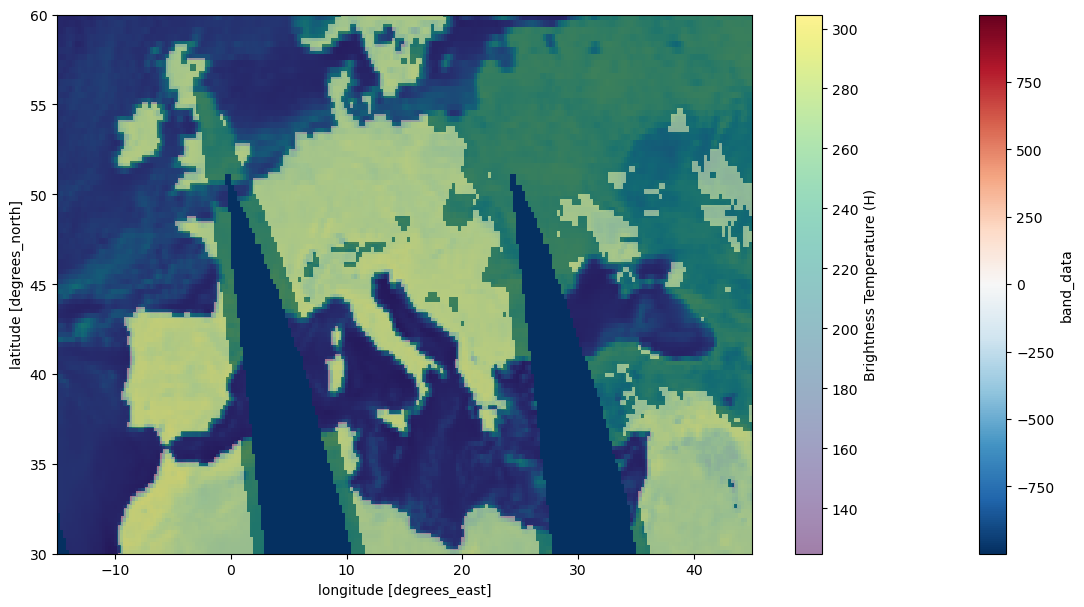

In [22]:
# Regular image plot:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize = (14,7))
r_dataset.sel(band=3).plot(x = "lon", y ="lat", ax = ax)

# bplot and compare with v2 data
v2_data["Brightness Temperature (H)"].plot(x = "lon", y ="lat", ax = ax, alpha = 0.5)

x_lims = (-15,45)
y_lims = (30,60)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])

(20.0, 70.0)

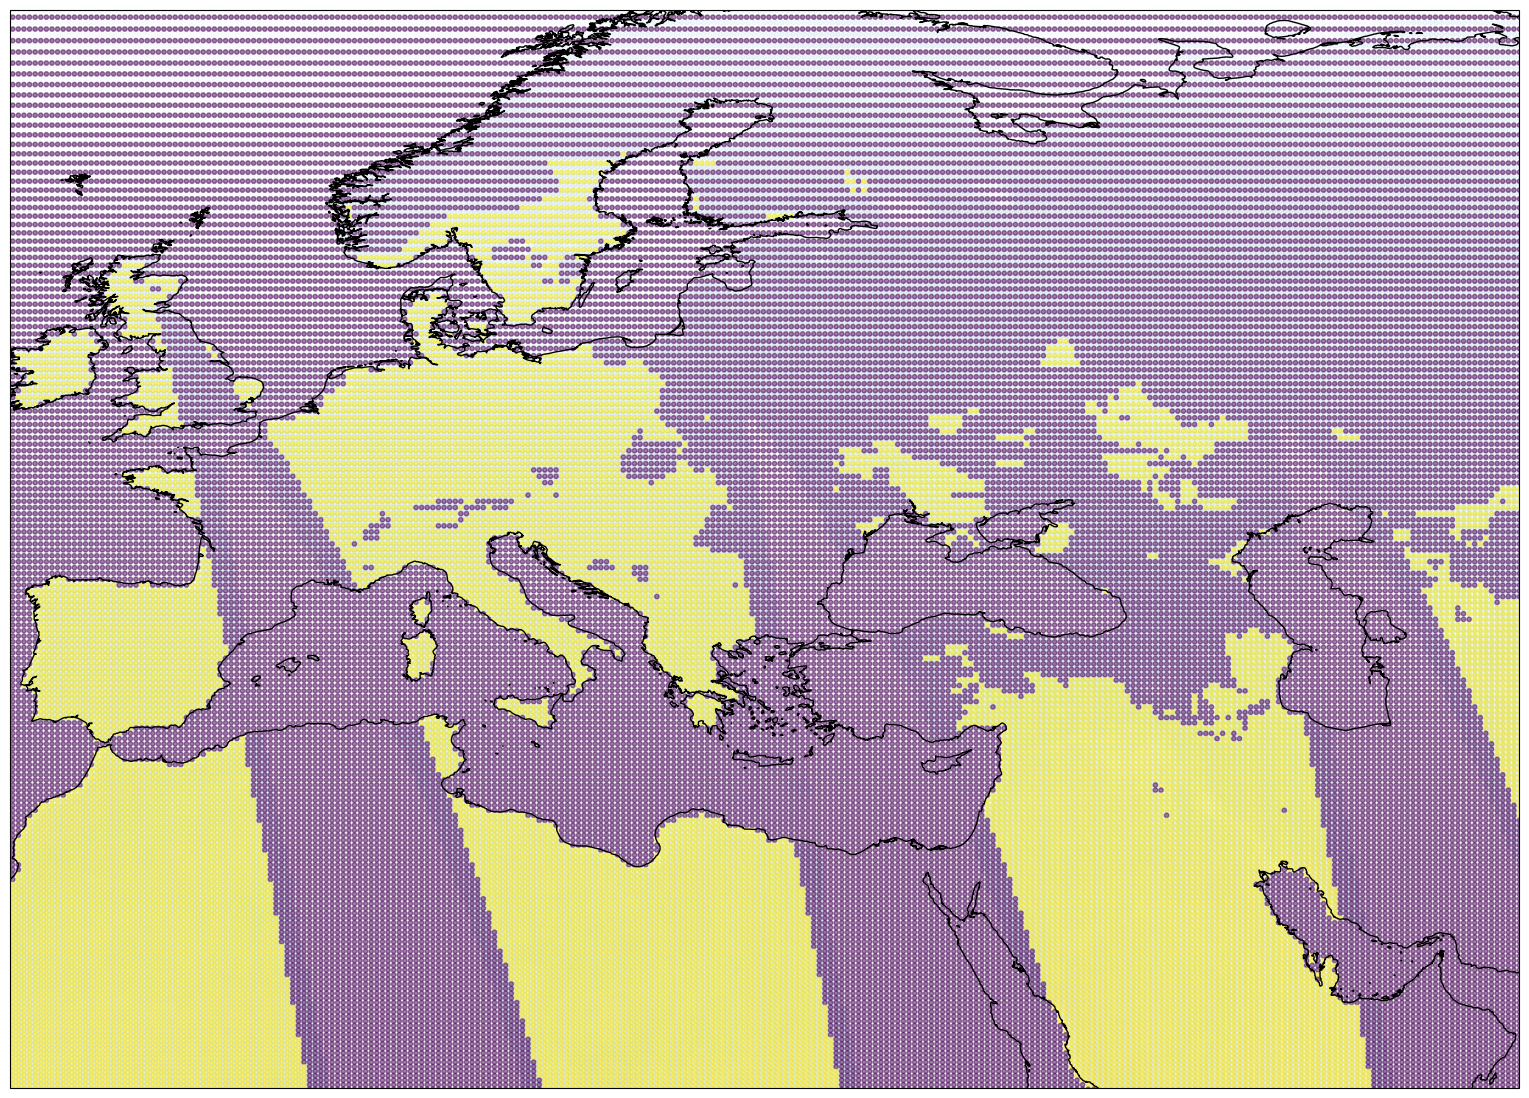

In [23]:
# Plot the pixel locations to make sure we projected properly:
# Scatterplot of the pixel locations:
# Extract the projected coordiantes as points. Do a meshgrid with lon and lat
lon1, lat1 = np.meshgrid(r_dataset.lon.values, r_dataset.lat.values)
lon1 = lon1.flatten()
lat1 = lat1.flatten()

# Do the same with the original V1 coordiantes
lon2, lat2 = np.meshgrid(v2_data.lon.values, v2_data.lat.values)
lon2 = lon2.flatten()
lat2 = lat2.flatten()

#Add the coastile objects to the lat-lon plot
import cartopy.crs as ccrs

fig,ax = plt.subplots(1,1,figsize=(28,14), subplot_kw={"projection":ccrs.PlateCarree()})
ax.coastlines("10m")
ax.scatter(lon2,lat2,s=10, c=v2_data["Brightness Temperature (H)"].values, alpha=0.1, marker = 'o', cmap="Blues")

#
ax.scatter(lon1,lat1,s=10,c=r_dataset.sel(band=3), alpha=0.5, marker = 'o', cmap="viridis")

x_lims = (-10,60)
y_lims = (20,70)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])